In [1]:
import sys
sys.path.insert(0, '../gambit')

import os
import sep
import numpy as np
import itertools
from scipy import ndimage
import matplotlib.pyplot as plt

from gambit import create_diff_per_image, clean_data, create_diff_image
from mask import create_segmentation_masks, create_ellipse_mask_from_sep_object
from fits import read_fits, view_fits, write_fits
from spin_parity import read_spin_parity_galaxies_label_from_csv

In [2]:
#DON'T change this:
bands_in_order = ['g','r','i','z','y']

In [3]:
#Change this:
path_to_input = "C:\\Users\\school\\Desktop\\github\\spin-parity-catalog\\original\\galaxies\\"
csv_path = "C:\\Users\\school\\Desktop\\github\\spin-parity-catalog\\table_info\\csv_format_of_table\\"

In [16]:
 #Update these as needed:
table_key = "table3"
use_percentile = True #True -> Percentile, False -> Norm
use_sep = True

In [17]:
def get_galaxy_list():
    return os.listdir(os.path.join(path_to_input,table_key))

def fits_path(name,band):
    return os.path.join(path_to_input,table_key,name,"{}_{}.fits".format(name,band))

def get_csv_path():
    return os.path.join(csv_path,"table_{}.csv".format(table_key.strip()[-1]))

In [18]:
#sep object:
def calc_dist(cm_x,cm_y,el_x,el_y):
    return (((cm_x-el_x)*(cm_x-el_x)) + ((cm_y-el_y)*(cm_y-el_y)))**0.5

def calc_sep_size(a,b):
    return 3.14*a*b

def run_sep(data, cm_x, cm_y):
    #print(np.min(data),np.max(data),np.sum(np.isinf(data)),np.sum(np.isnan(data)))
    data = data.byteswap().newbyteorder()
    bkg = sep.Background(data)
    data_sub = data - bkg
    
    objects = sep.extract(data_sub, 1.5, err=bkg.globalrms)
    #view_fits_with_sep_objects(data,objects,2)
    
    the_el_sep = None
    the_el_sep_dist = np.inf
    
    #return
    
    for i in objects:
        #print(i['a'],i['b'],i['x'],i['y'])
        if calc_sep_size(i['a'],i['b']) < 0.001*data.shape[0]*data.shape[1]: continue
        
        d = calc_dist(cm_x,cm_y,i['x'],i['y'])
        if d < the_el_sep_dist:
            the_el_sep = i; the_el_sep_dist = d
            
    if the_el_sep != None:
        the_el = create_ellipse_mask_from_sep_object(the_el_sep,data.shape,r=2)
        #view_fits(the_el)
        return the_el
    return None

In [19]:
def calculate_center_of_mass(the_mask):
    return ndimage.center_of_mass(the_mask)

def get_cms(diff_per,foreground):
    thresholds = []
    above_threshold_cm = []
    below_threshold_cm = []
    
    m, s = np.mean(diff_per[foreground]), np.std(diff_per[foreground])
    
    for i in np.linspace(m-1*s,m+1*s):
        above_area = np.logical_and(foreground,diff_per>=i)
        below_area = np.logical_and(foreground,diff_per<i)
        
        thresholds.append(i)
        above_threshold_cm.append(calculate_center_of_mass(above_area))
        below_threshold_cm.append(calculate_center_of_mass(below_area))
        
    return (thresholds,above_threshold_cm,below_threshold_cm)
        
def diff_cm(diff,foreground, std_range=1):
    xu = []; yu = [] #for above threshold
    xl = []; yl = [] #for below threshold
    
    m, s = np.mean(diff[foreground]), np.std(diff[foreground])
    
    for i in np.linspace(m-std_range*s,m+std_range*s):
        upper_clip = np.logical_and(foreground,diff>=i) #points above threshold
        lower_clip = np.logical_and(foreground,diff<i) #points below threshold
        
        u_cm = calculate_center_of_mass(upper_clip) #center of mass of above threshold
        l_cm = calculate_center_of_mass(lower_clip) #center of mass of below threshold

        xu.append(u_cm[0]);yu.append(u_cm[1])
        xl.append(l_cm[0]);yl.append(l_cm[1])
        
    return (xu,yu,xl,yl)

def visualize_diff_cm(diff,foreground,xu,yu,xl,yl):
    fig, ax = plt.subplots(figsize=(30,20))
    im = ax.imshow(diff, interpolation='nearest', cmap='gray', origin='lower')
    ax.plot(calculate_center_of_mass(foreground)[0],calculate_center_of_mass(foreground)[1], marker='v',color='green')
    ax.plot(xu, yu, color="blue", linewidth=3, alpha=0.5) #center of mass for pixels above threshold
    ax.plot(xl, yl, color="red", linewidth=3, alpha=0.5) #center of mass for pixels below threshold
    plt.show()
    

In [20]:
def construct_diff_percentile(name,first_band,base_band):
    first_band_path = fits_path(name,first_band)
    base_band_path = fits_path(name,base_band)
    
    if not (os.path.exists(first_band_path) and os.path.exists(base_band_path)): 
        print("path does not exist gaurd")
        return None

    first_band_data = clean_data(read_fits(first_band_path)) #added clean to handle infs/ nans
    base_band_data = clean_data(read_fits(base_band_path)) #added clean to handle infs/ nans
    
    if first_band_data.shape != base_band_data.shape: 
        print("shape issue gaurd")
        return None
    
    (foreground,_) = create_segmentation_masks(base_band_data)
    cm_y, cm_x = calculate_center_of_mass(foreground)
    
    if np.sum(foreground) <= 0.01*np.sum(np.shape(base_band_data)): 
        print("small forground gaurd")
        return None
    
    if use_sep:
        the_el = run_sep(base_band_data, cm_x, cm_y)
        if the_el is None:
            print("issue with sep guard")
            return None
        foreground = the_el
    
    if use_percentile:
        diff = create_diff_per_image(first_band_data,base_band_data,foreground)
    else:
        diff = create_diff_image(first_band_data,base_band_data,foreground)
    
    #one way to visualize cm:
    (xu,yu,xl,yl) = diff_cm(diff,foreground)
    visualize_diff_cm(diff,foreground,xu,yu,xl,yl)
    
    #TODO - Better understand diff: 
    #1) Visualize diff vs. distance from center (for now you can just use center of image)
    #2) Visualize diff vs. angle (see create_disk_angle_matrix in matrix.py, (h,k) center and theta is angle of ellipse, set to 0 for using standard math def.)
    #3) Are there any noticable differences between band pairs?
    #4) Are there any noticable differences table 2/4/5 and table 3?
    #5) Use 1-4 but with use_percentile = True

1 IC1151 nw


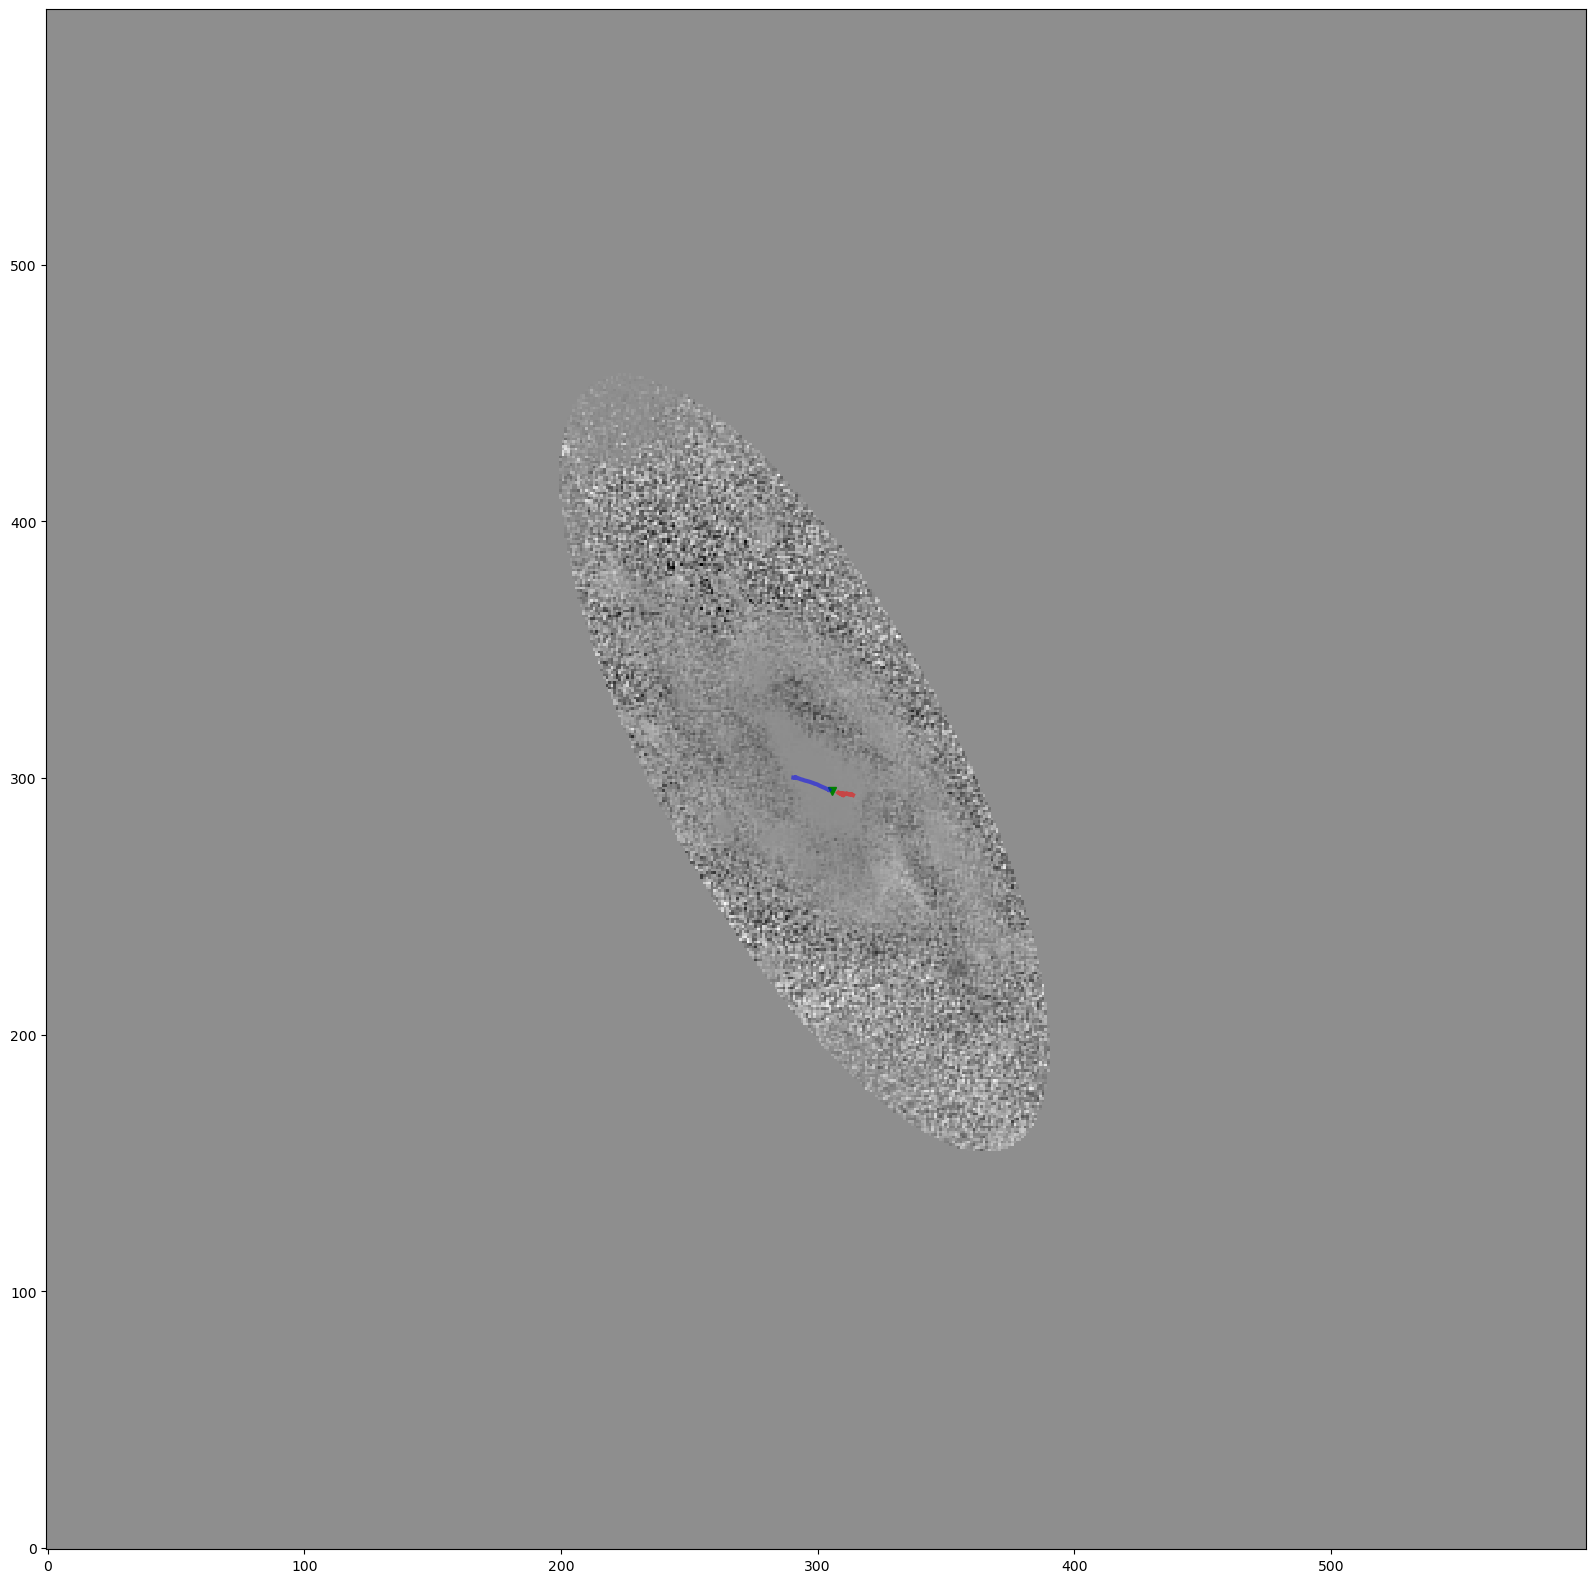

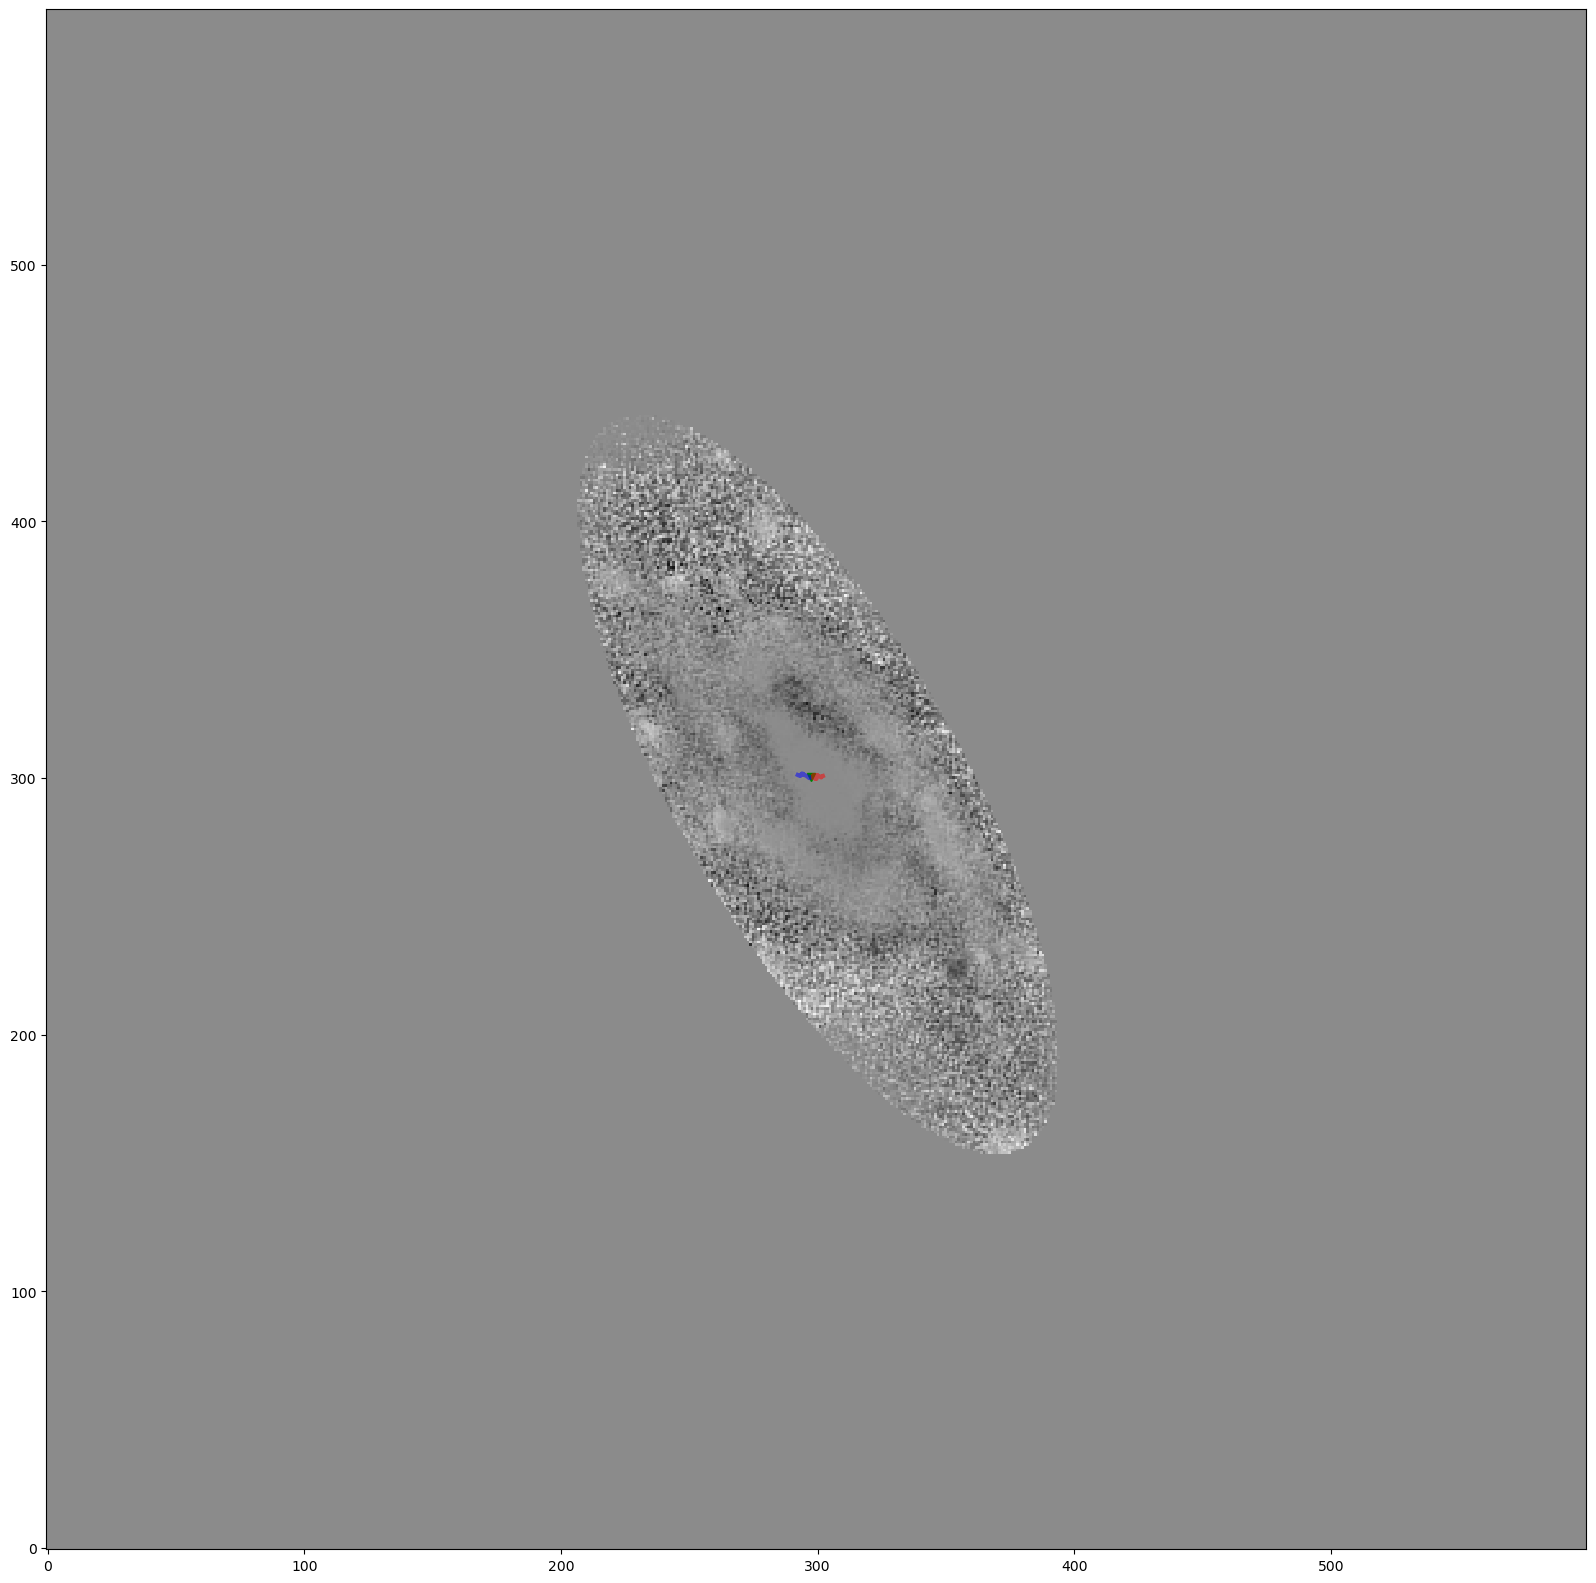

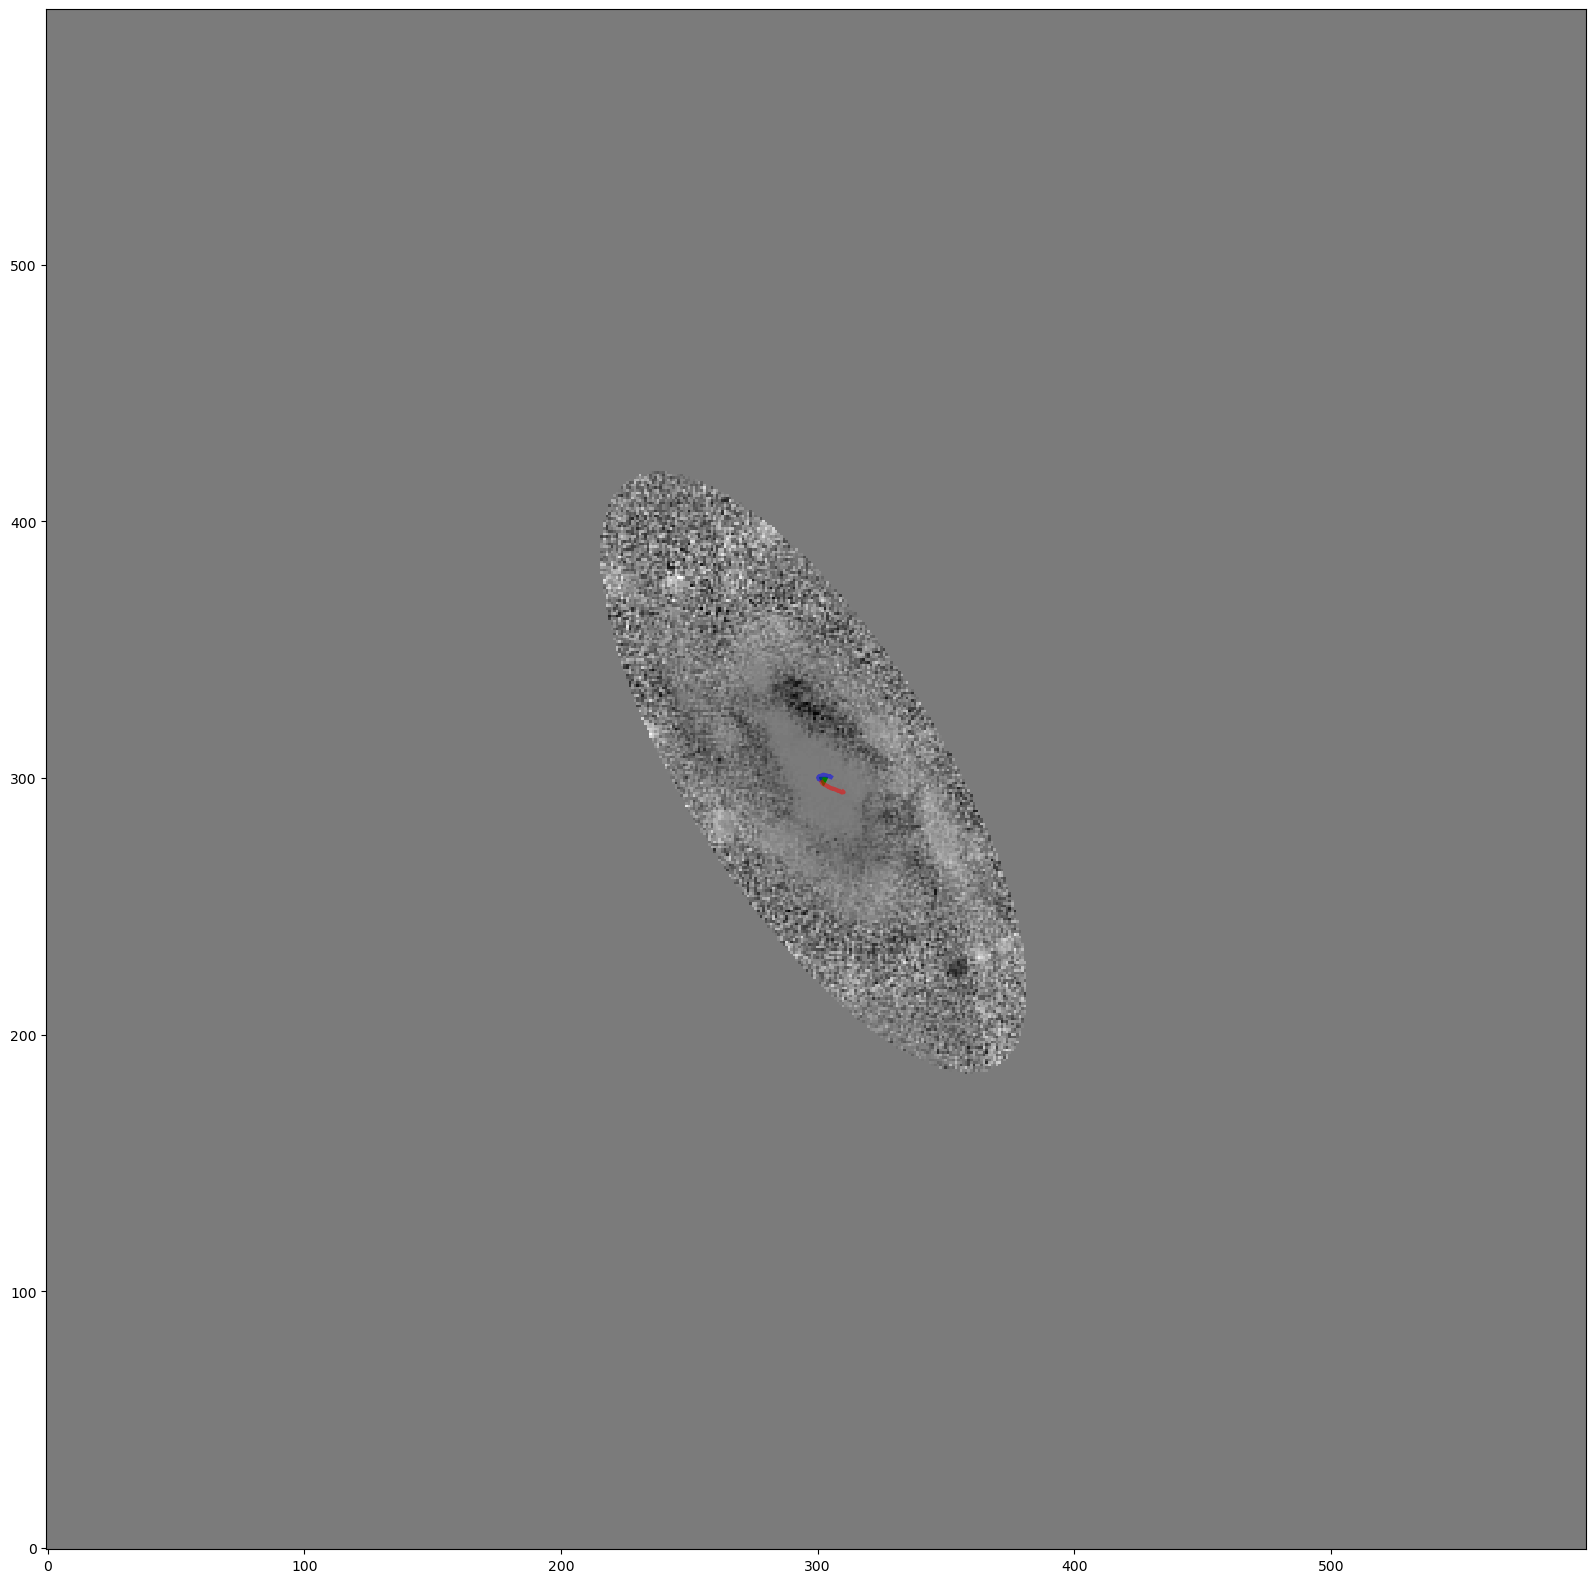

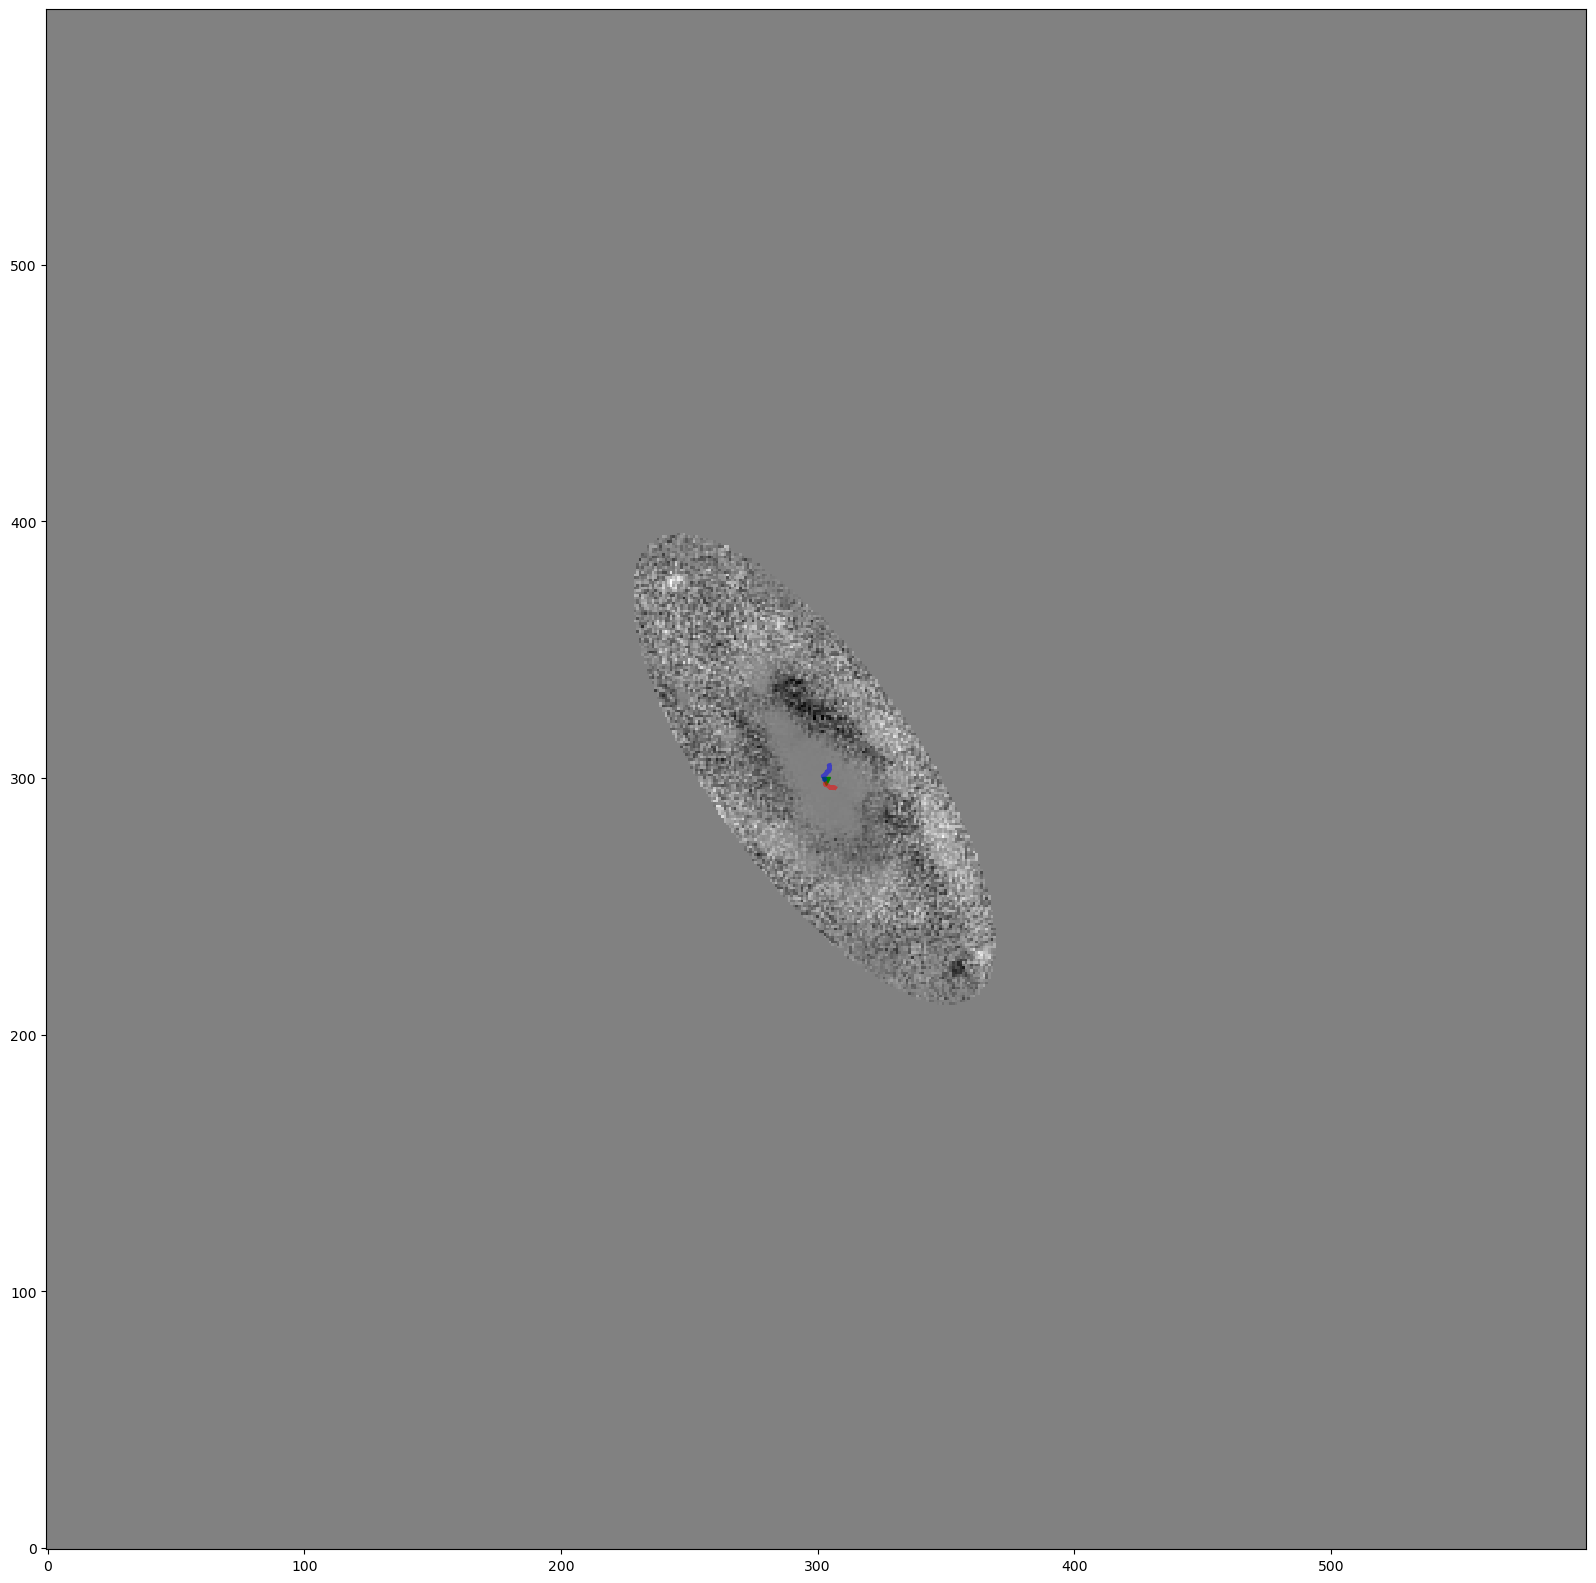

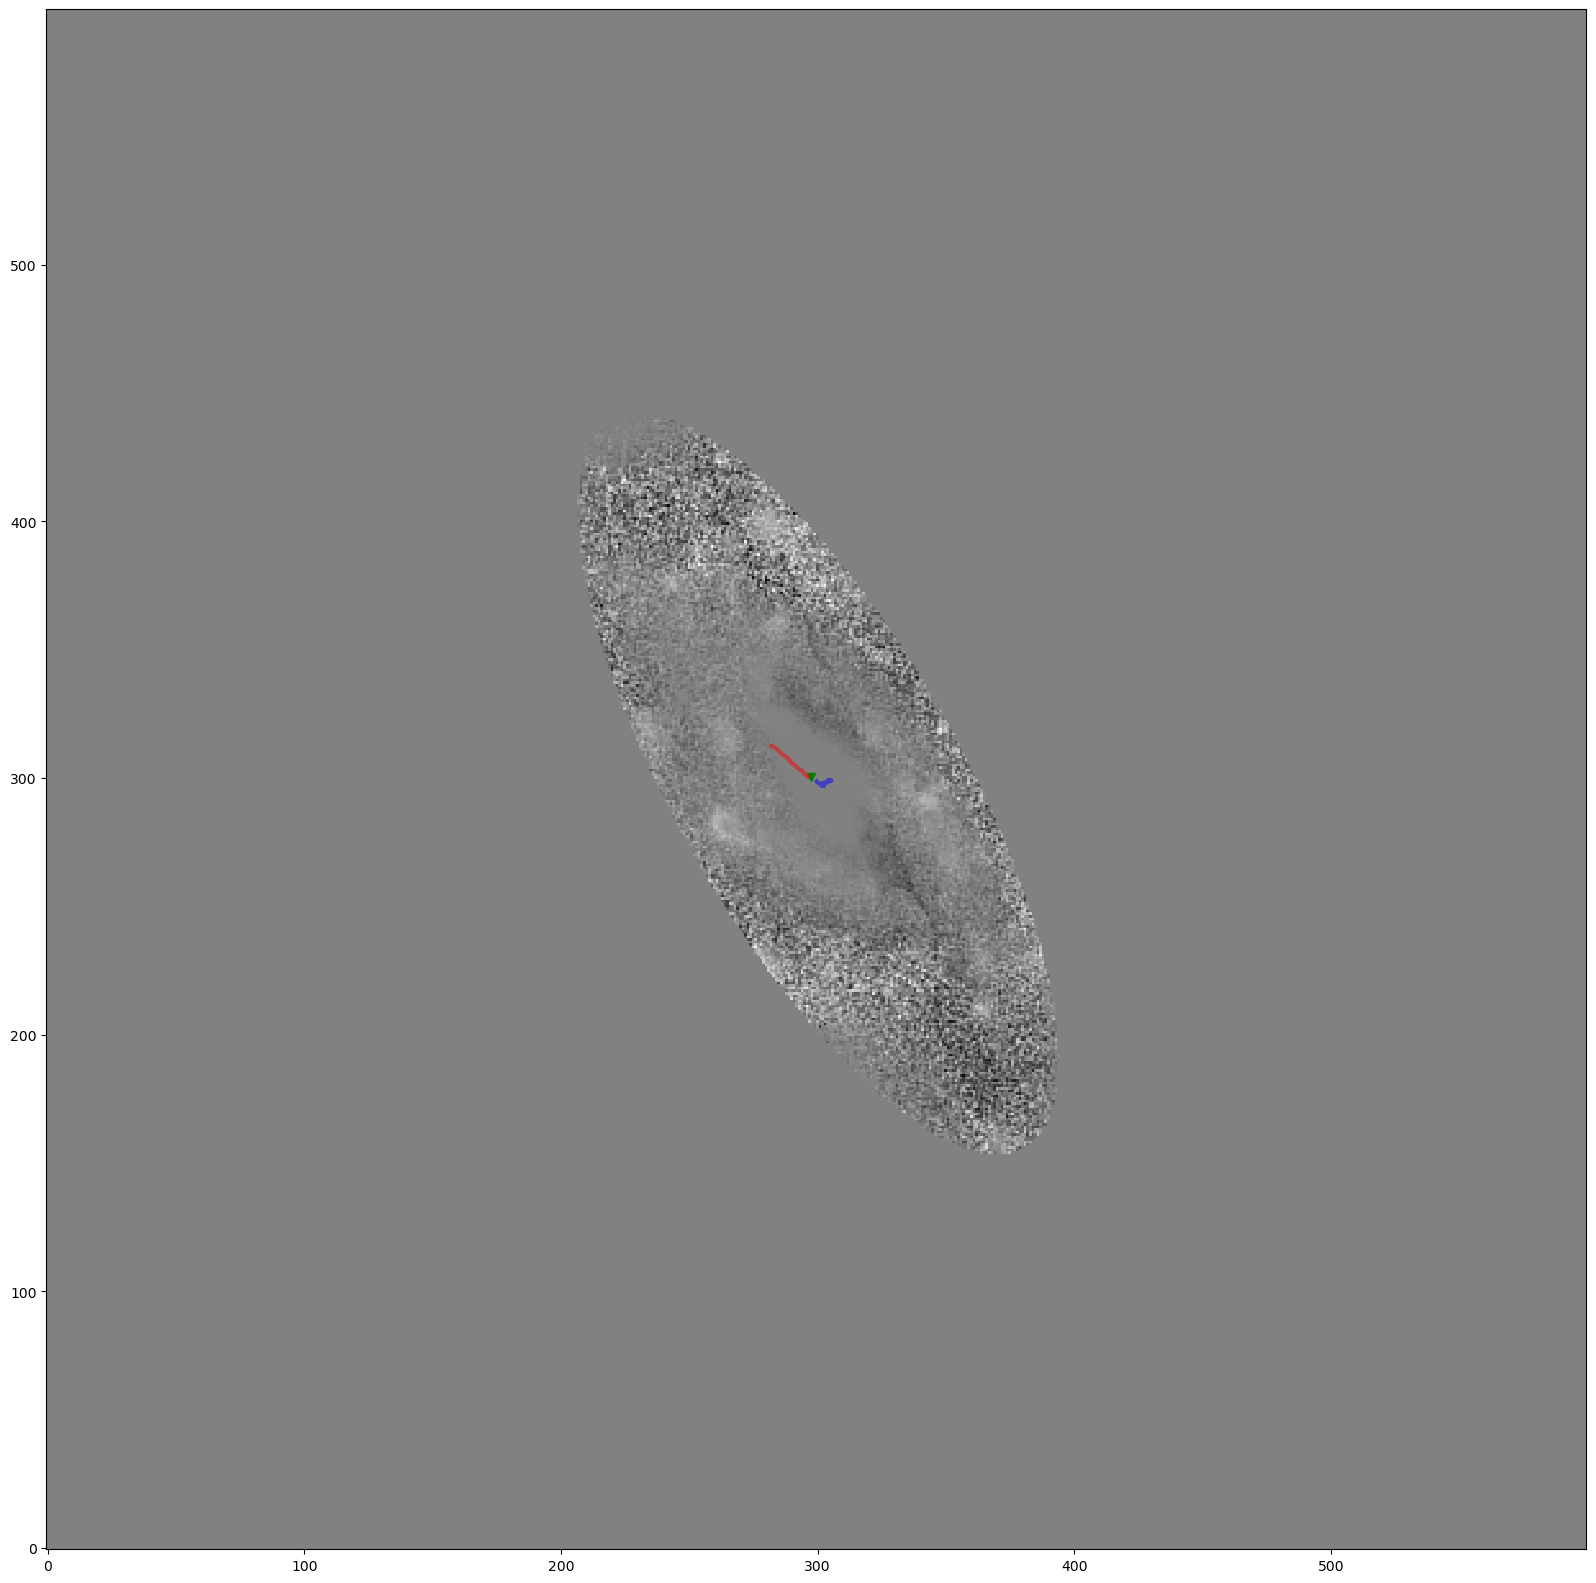

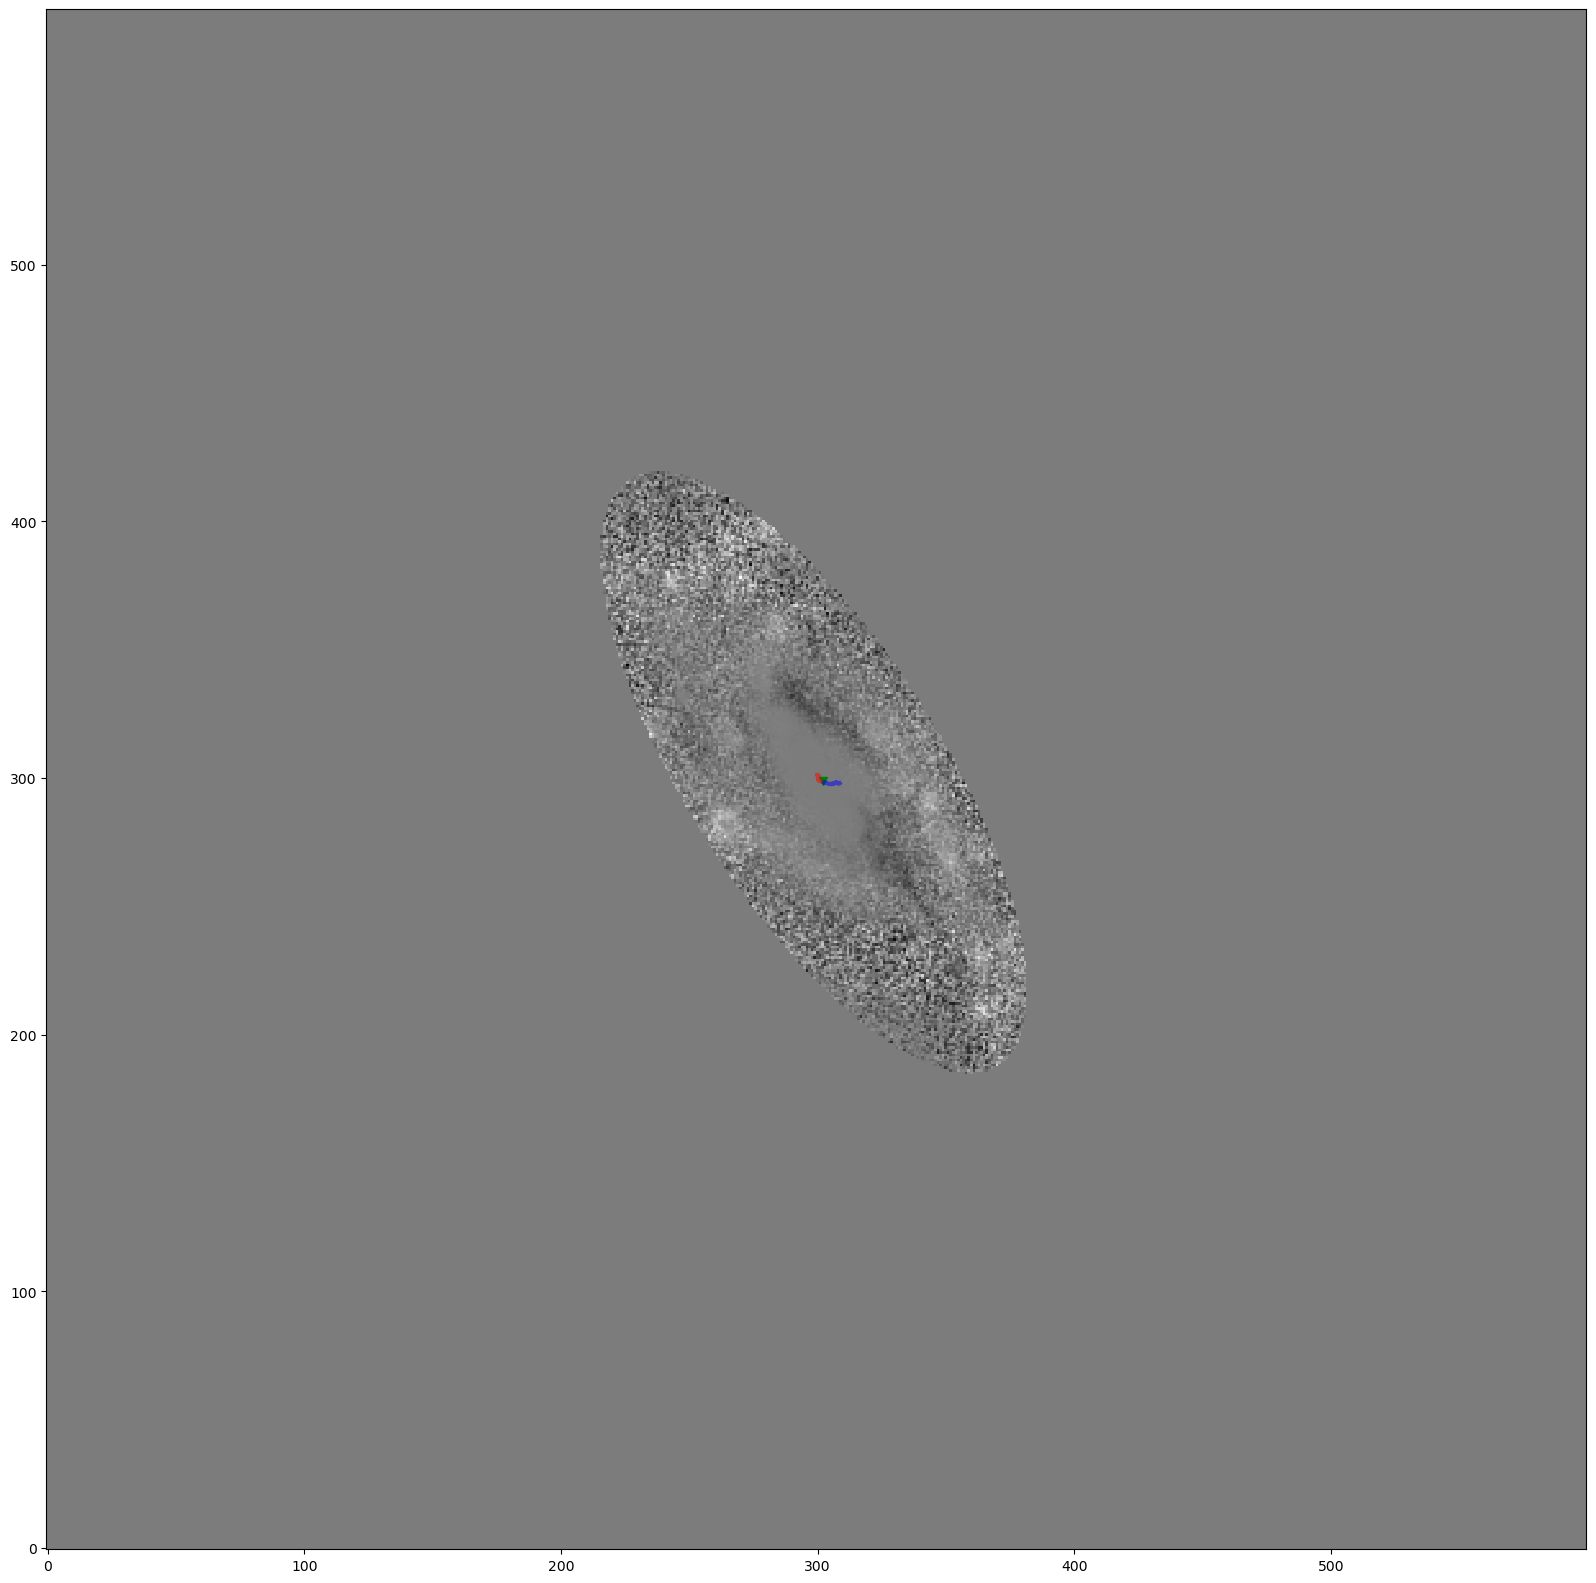

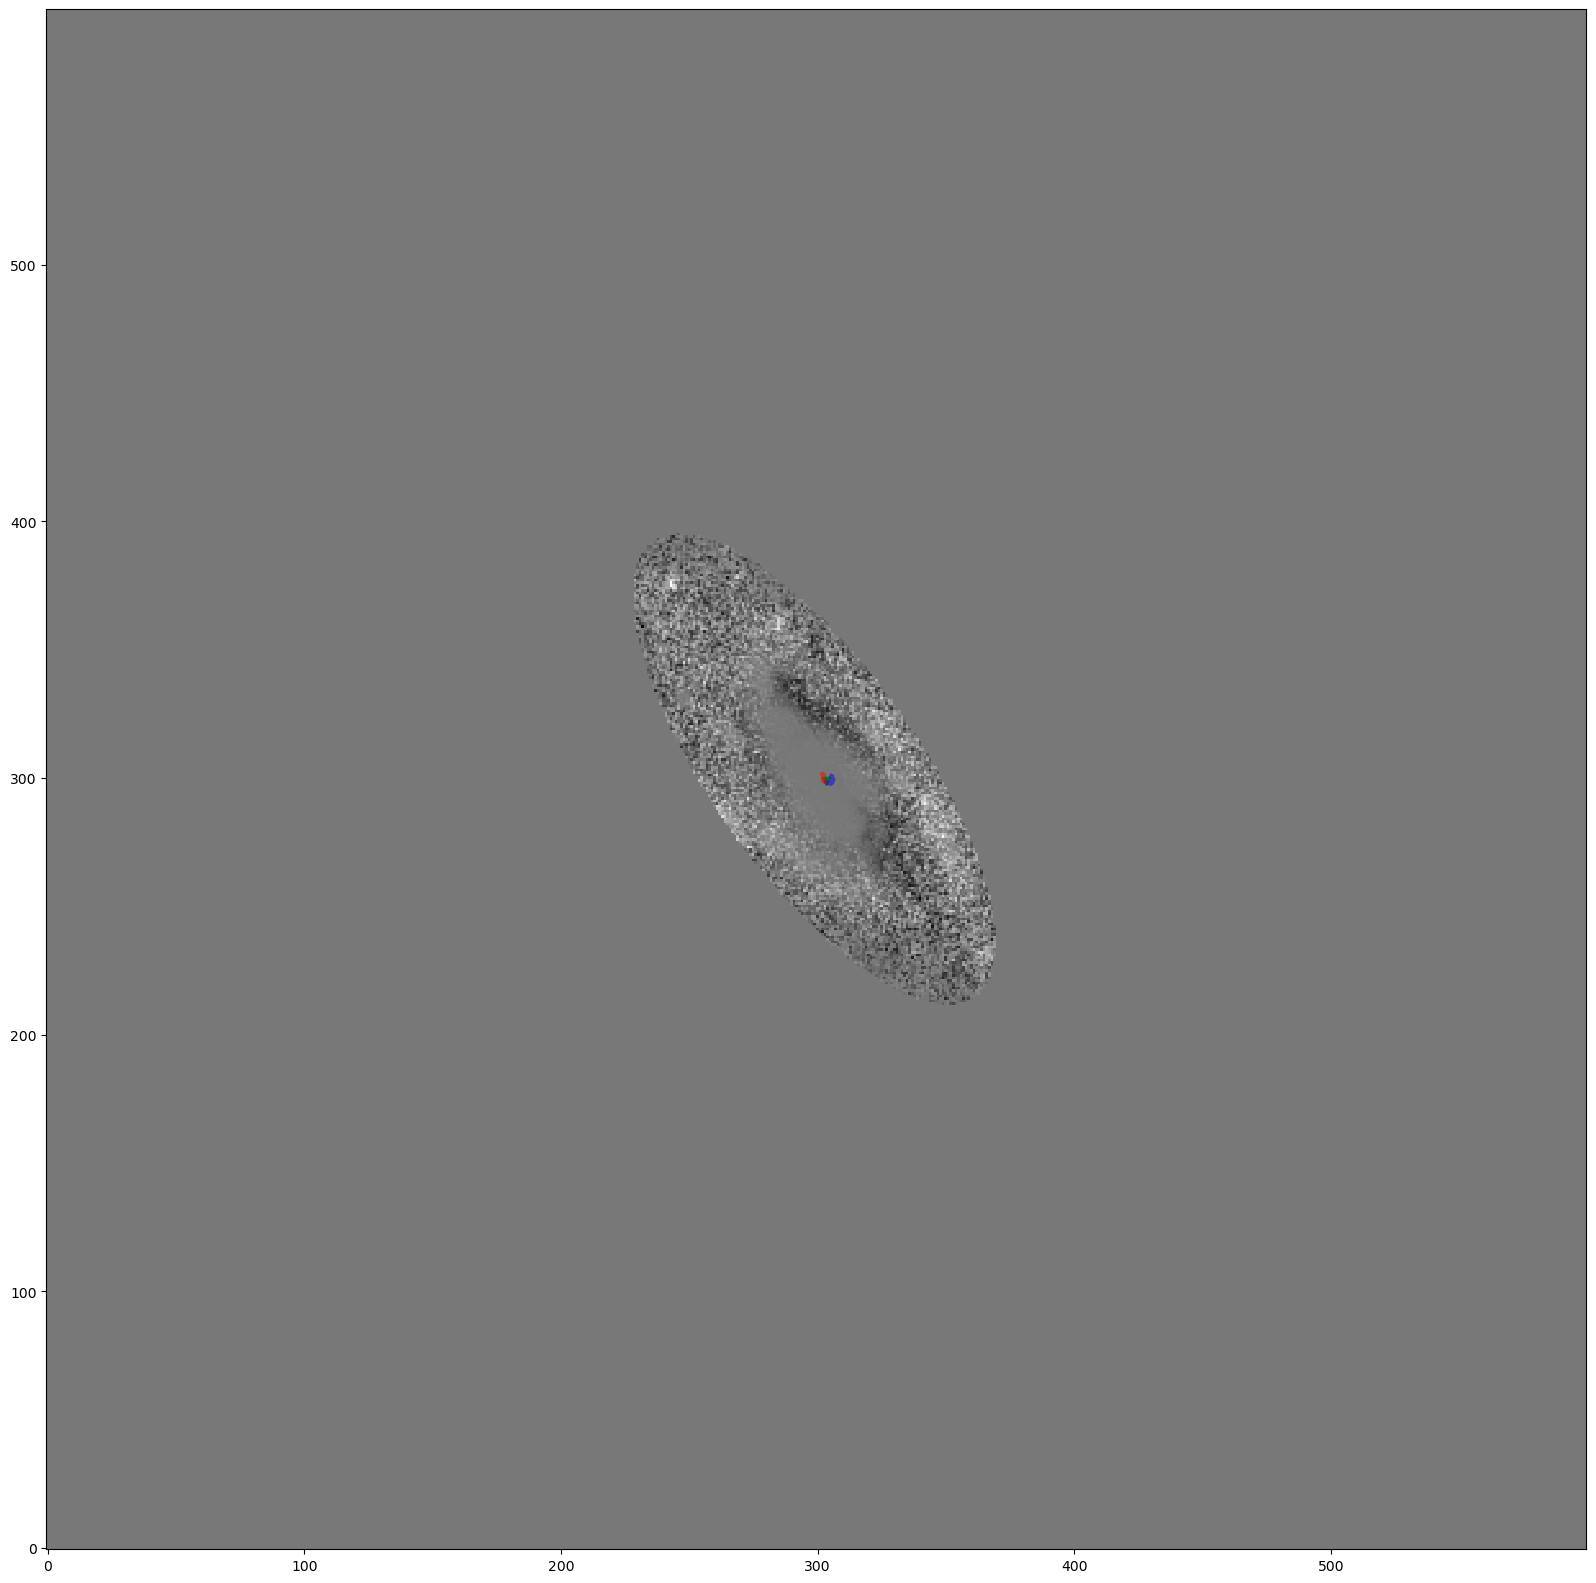

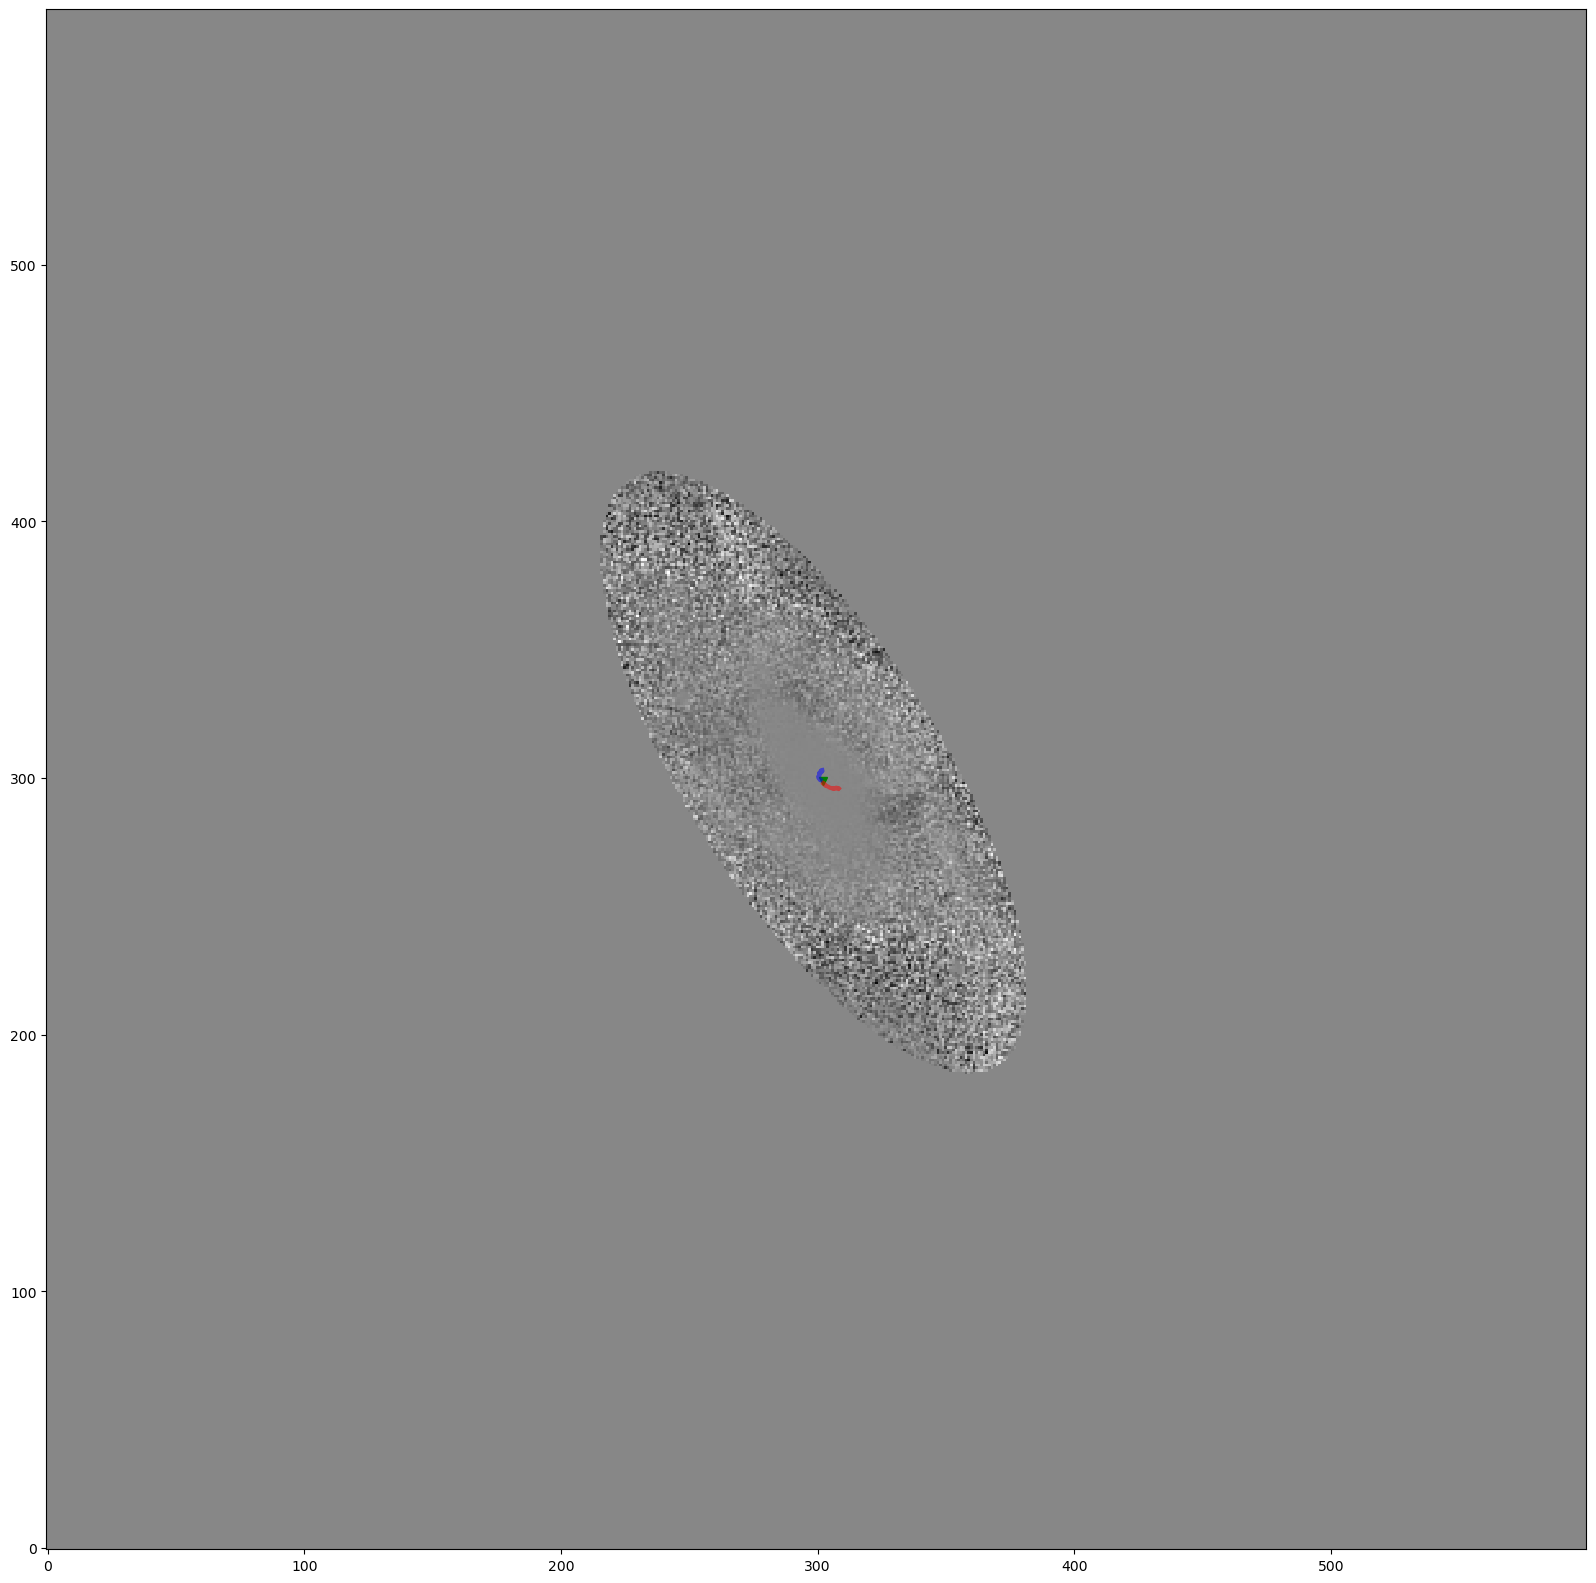

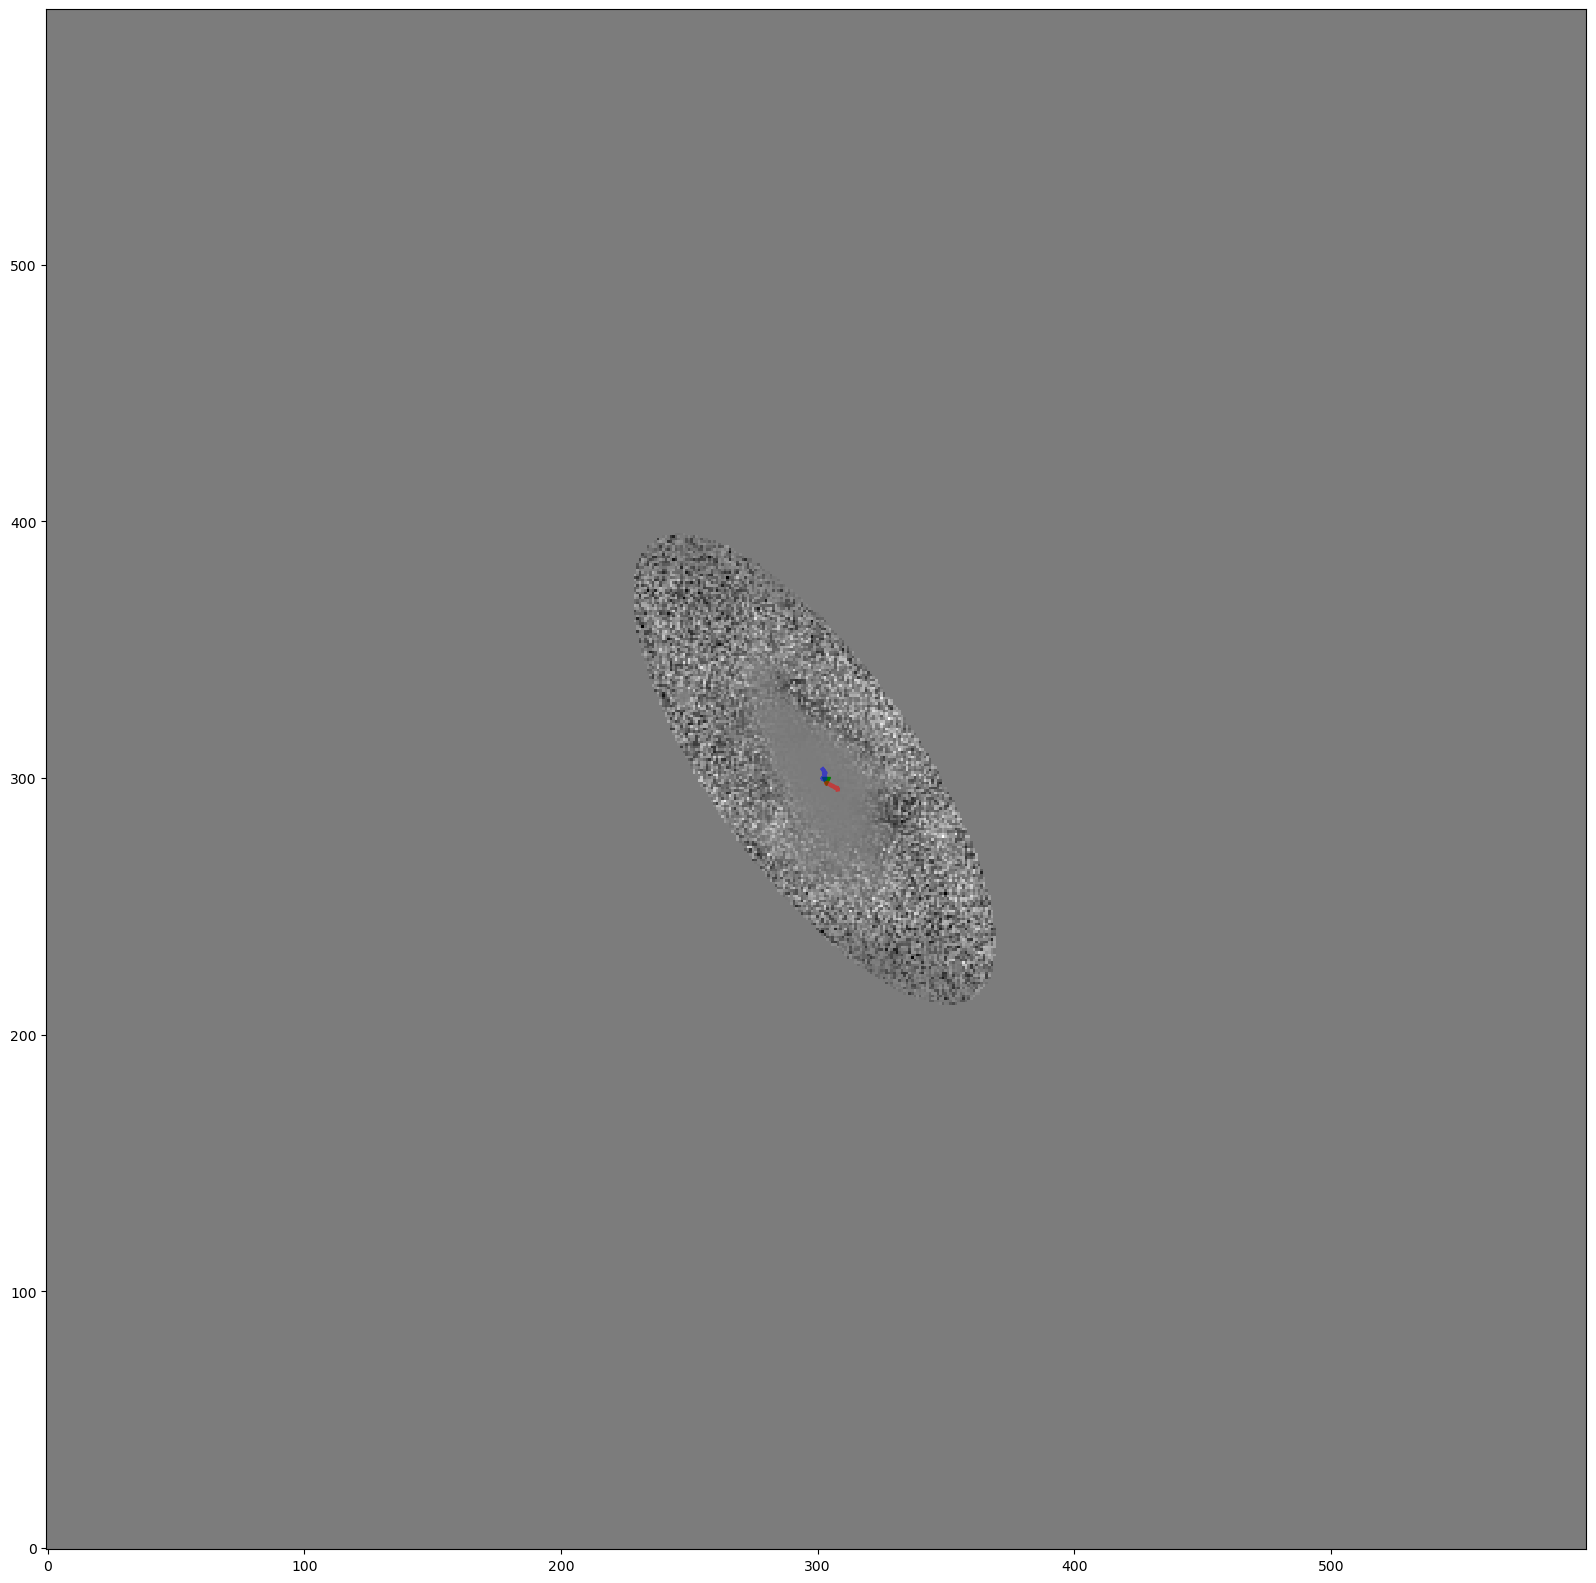

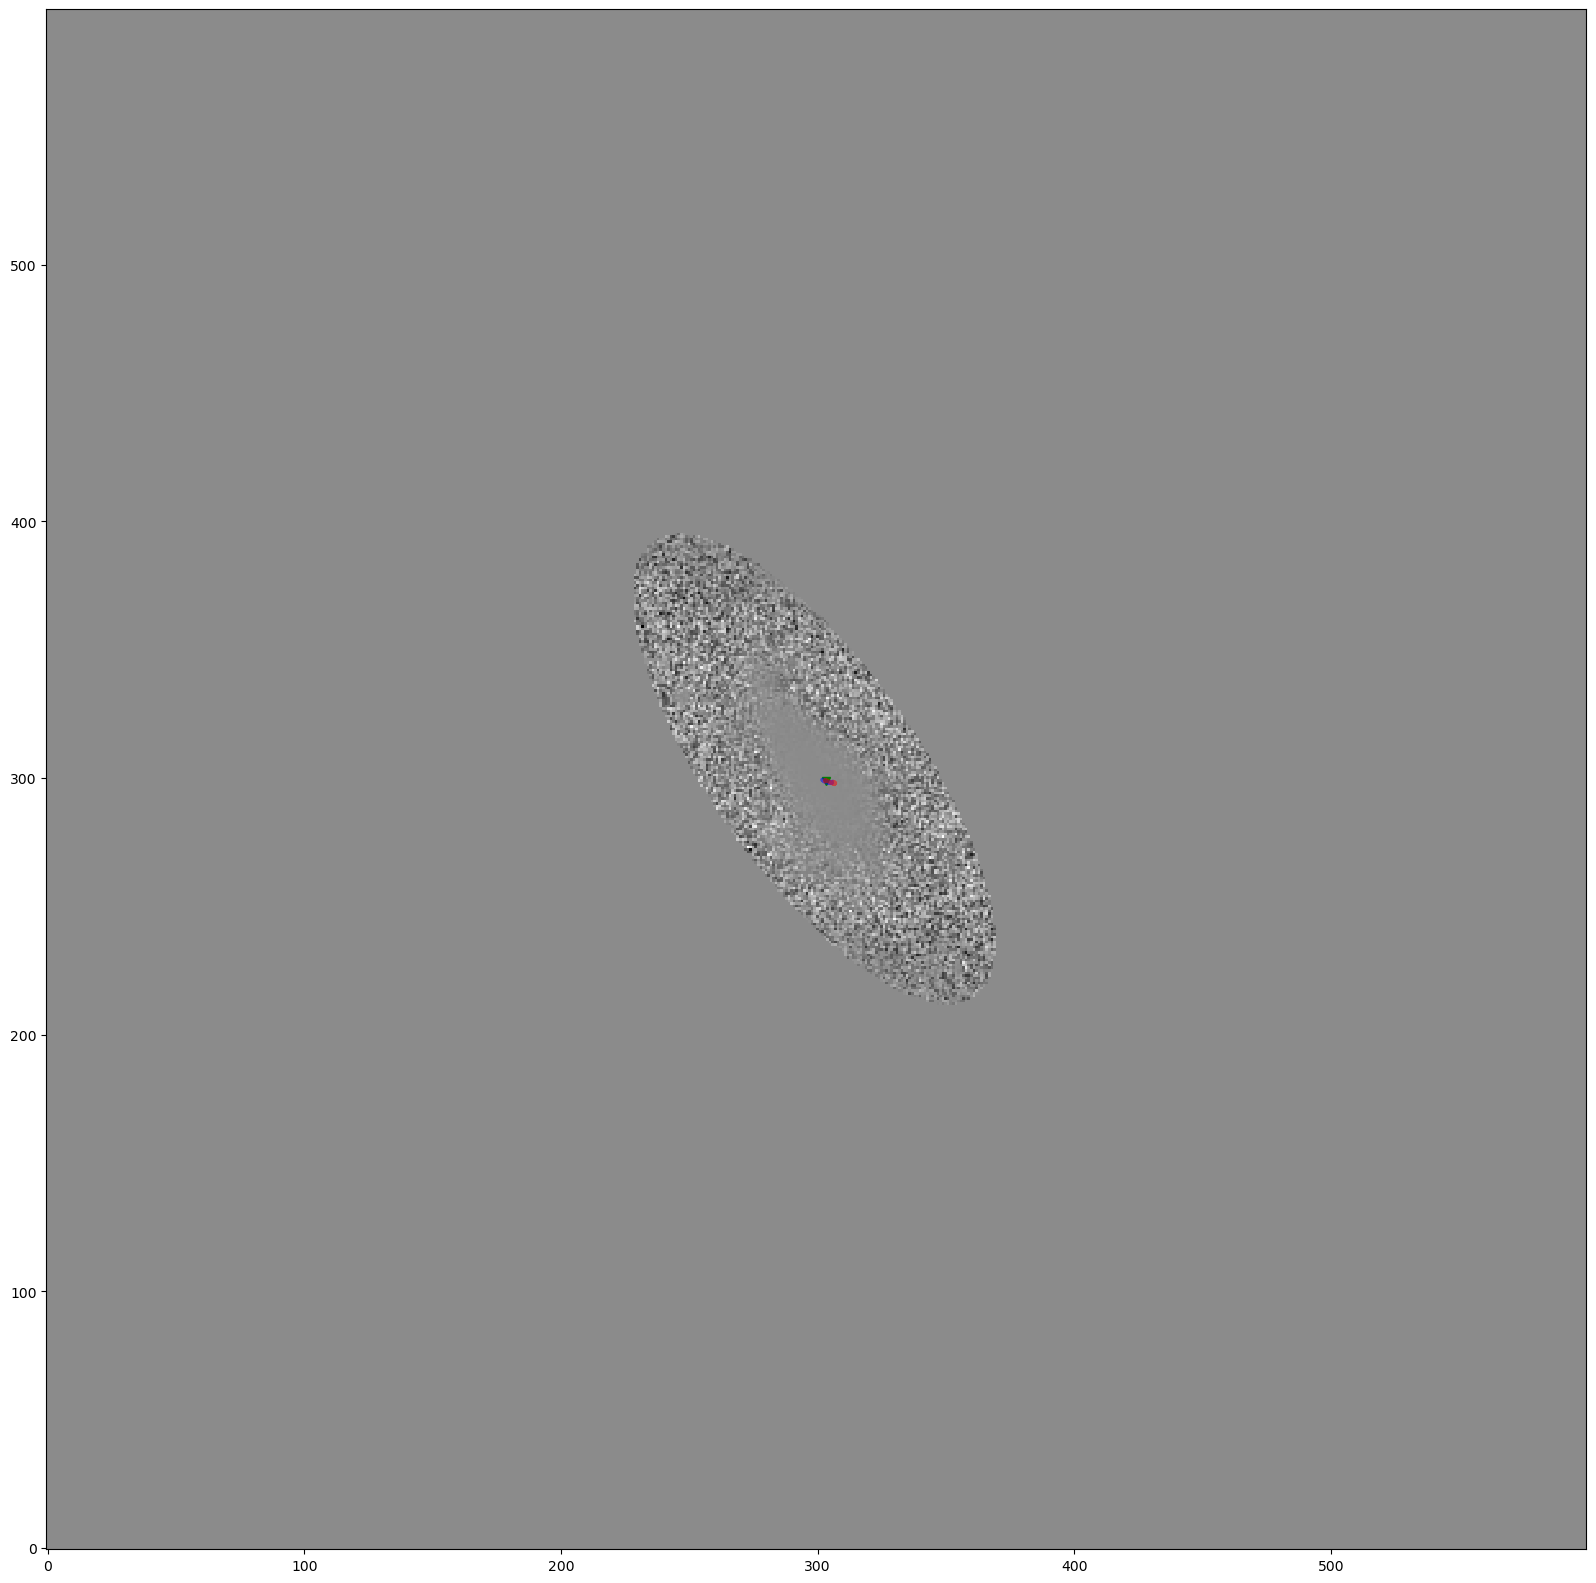

In [21]:
i = 1
dark_side = read_spin_parity_galaxies_label_from_csv(get_csv_path())

for name in get_galaxy_list():
    if name not in dark_side: continue
    print(i,name, dark_side[name])
    for (first_band,base_band) in itertools.combinations(bands_in_order, 2):
        construct_diff_percentile(name,first_band,base_band)
    i += 1
    if i > 2:
        break
    break